# 데이터 전처리

In [26]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [27]:
# ✅ 훈련 데이터 전처리 (데이터 증강 포함)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),                     # 크롭 전 여유 공간 확보
    transforms.CenterCrop(224),                        # 중심부 크롭 (폐 중심)
    transforms.RandomHorizontalFlip(p=0.5),            # 좌우 반전 증강
    transforms.RandomRotation(10),                     # 회전 증강
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기/대비 증강
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],         # ImageNet 평균
                         [0.229, 0.224, 0.225])         # ImageNet 표준편차
])

# ✅ 검증 및 테스트 데이터 전처리 (증강 없이 정규화만)
eval_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ 데이터셋 로딩
train_dataset = datasets.ImageFolder("C:/DL/data/chest_xray/train", transform=train_transform)
val_dataset   = datasets.ImageFolder("C:/DL/data/chest_xray/val", transform=eval_transform)
test_dataset  = datasets.ImageFolder("C:/DL/data/chest_xray/test", transform=eval_transform)

# ✅ 데이터로더 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

# 모델 불러오기

In [28]:
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# EfficientNet-b0 불러오기
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, 2)  # 클래스 수: NORMAL vs PNEUMONIA
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


# 학습 루프

In [ ]:
import torch.optim as optim

# 클래스별 샘플 수 확인
from collections import Counter
print(Counter(train_dataset.targets))  # 또는 train_dataset.labels

# Weighted Loss 적용
weights = torch.tensor([1.5, 1.0]).to(device)  # NORMAL에 더 높은 가중치
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} | Training Loss: {running_loss:.4f}")

Epoch 1 | Training Loss: 30.5694
Epoch 2 | Training Loss: 10.7160
Epoch 3 | Training Loss: 7.2429
Epoch 4 | Training Loss: 6.3457
Epoch 5 | Training Loss: 5.4809
Epoch 6 | Training Loss: 3.9978
Epoch 7 | Training Loss: 3.6597
Epoch 8 | Training Loss: 2.5943
Epoch 9 | Training Loss: 3.0253
Epoch 10 | Training Loss: 1.9974


# 검증 및 테스트

Validation F1 Score (weighted): 0.65
Classification Report:
               precision    recall  f1-score   support

      NORMAL       1.00      0.38      0.55         8
   PNEUMONIA       0.62      1.00      0.76         8

    accuracy                           0.69        16
   macro avg       0.81      0.69      0.65        16
weighted avg       0.81      0.69      0.65        16



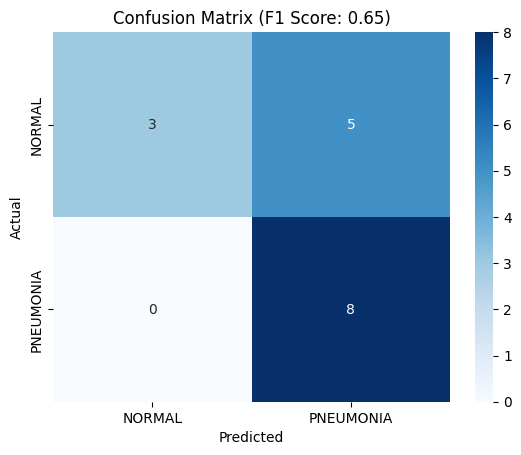

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


예측 결과: [0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1], 정답: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


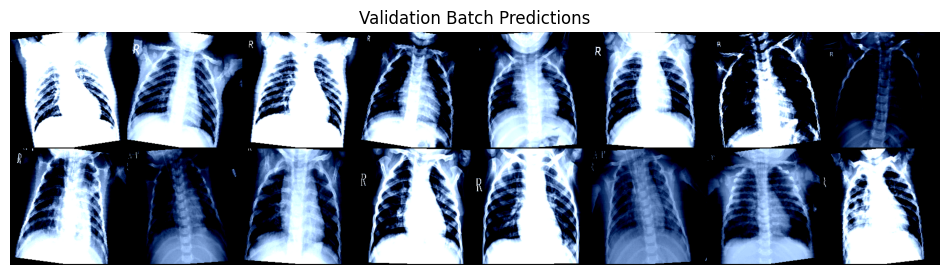

최종 검증 정확도: 75.00%


In [18]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision

# 검증 평가
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# F1 Score 및 리포트 출력
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Validation F1 Score (weighted): {f1:.2f}")

target_names = train_dataset.classes
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix 시각화
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix (F1 Score: {f1:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 🔍 예측 결과 시각화 및 정확도 계산
total_pred = 0

with torch.no_grad():
    for data, label in val_loader:
        data, label = data.to(device), label.to(device)
        pred = model(data)
        pred = torch.max(pred, 1)[1]

        total_pred += torch.sum(pred == label).item()

        print(f'예측 결과: {pred.cpu().numpy()}, 정답: {label.cpu().numpy()}')

        images_data = torchvision.utils.make_grid(data.cpu())
        plt.figure(figsize=(12, 6))
        plt.imshow(images_data.permute(1, 2, 0))
        plt.axis("off")
        plt.title("Validation Batch Predictions")
        plt.show()

# 최종 정확도 출력
val_accuracy = total_pred / len(val_loader.dataset)
print(f'최종 검증 정확도: {val_accuracy:.2%}')

In [11]:
import torchvision

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


예측 결과: tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]), 정답: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])


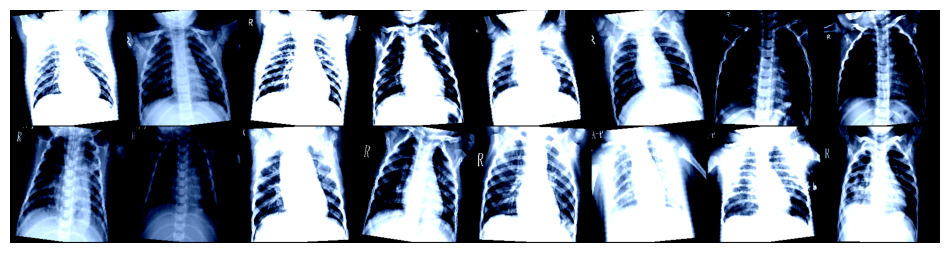

최종 정확도:  tensor(0.7500)


In [14]:
model.eval()
with torch.no_grad():
    for data, label in val_loader:
        pred = model(data.to(device))
        pred = torch.max(pred, 1)[1]

        total_pred = torch.sum(pred == label.to(device).data)

        print(f'예측 결과: {pred}, 정답: {label}')
        images_data = torchvision.utils.make_grid(data)
        plt.figure(figsize=(12, 6))
        plt.imshow(images_data.permute(1, 2, 0))       
        plt.axis("off")
        plt.show()

print('최종 정확도: ', total_pred/len(val_loader.dataset))

In [19]:
# 클래스별 샘플 수 확인
from collections import Counter
print(Counter(train_dataset.targets))  # 또는 train_dataset.labels

# Weighted Loss 적용
weights = torch.tensor([1.5, 1.0]).to(device)  # NORMAL에 더 높은 가중치
criterion = nn.CrossEntropyLoss(weight=weights)

Counter({1: 3875, 0: 1341})


In [20]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image

# Grad-CAM 클래스 정의
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, class_idx=None):
        self.model.eval()
        output = self.model(input_image)

        if class_idx is None:
            class_idx = torch.argmax(output)

        self.model.zero_grad()
        class_score = output[0, class_idx]
        class_score.backward()

        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        cam = cam.cpu().numpy()

        return cam

# 🔍 예시: Grad-CAM 시각화
def show_gradcam(model, image_tensor, target_layer, class_names):
    cam_generator = GradCAM(model, target_layer)
    cam = cam_generator.generate_cam(image_tensor)

    img = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    plt.figure(figsize=(8, 4))
    plt.imshow(img, alpha=0.6)
    plt.imshow(cam, cmap='jet', alpha=0.4)
    plt.title("Grad-CAM Visualization")
    plt.axis("off")
    plt.show()

In [22]:
# 모델 구조 출력
print(model)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

c:\DL\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\DL\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\82104/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 61.2MB/s]
c:\DL\.venv\Lib\site-packages\torch\nn\modules\module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  try:


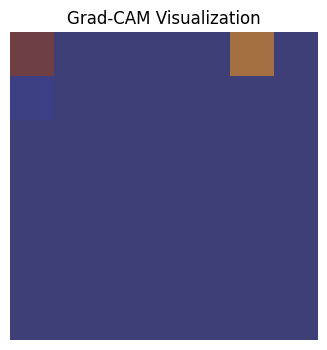

In [24]:
from torchvision.models import efficientnet_b0

# 모델 로드
model = efficientnet_b0(pretrained=True)
model.to(device)

# Grad-CAM 대상 레이어 지정
target_layer = model.features[6][0]  # 또는 model.features[-1][0]

# 이미지 준비
sample_image, _ = val_dataset[0]
sample_tensor = sample_image.unsqueeze(0).to(device)

# Grad-CAM 시각화 실행
show_gradcam(model, sample_tensor, target_layer, class_names=['NORMAL', 'PNEUMONIA'])